## Ребров. Исследование качества белого вина  
  
data set: http://www3.dsi.uminho.pt/pcortez/wine/

In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import row
from bokeh.io import output_notebook
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
import sklearn
import sklearn.metrics
from sklearn import ensemble
from sklearn import linear_model
output_notebook()
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Loading BokehJS ...

In [125]:
#загружаю датасет
df = pd.read_csv("winequality-white.csv", delimiter=';')

In [168]:
#переименую переменные на русском языке
df.rename(
    columns=({ 'fixed acidity': 'фикс. кислотность', 'volatile acidity': 'летучая кислотность', 
              'citric acid': 'лимонная кислота', 'residual sugar': 'остаточный сахар',
       'chlorides': 'хлориды', 'free sulfur dioxide': 'своб. диоксид серы', 'total sulfur dioxide': 'общ. диоксид серы',
              'density': 'плотность',
     'sulphates': 'сульфаты', 'alcohol': 'спирт', 'quality': 'качество'}), 
    inplace=True,
)

Исследую датасет:

In [127]:
print("количество элементов датасета: {s}".format(s = df.shape))
print("Названия колонок: {s}".format(s = list(df)))
df.info()

количество элементов датасета: (4898, 12)
Названия колонок: ['фикс. кислотность', 'летучая кислотность', 'лимонная кислота', 'остаточный сахар', 'хлориды', 'своб. диоксид серы', 'общ. диоксид серы', 'плотность', 'pH', 'сульфаты', 'спирт', 'качество']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   фикс. кислотность    4898 non-null   float64
 1   летучая кислотность  4898 non-null   float64
 2   лимонная кислота     4898 non-null   float64
 3   остаточный сахар     4898 non-null   float64
 4   хлориды              4898 non-null   float64
 5   своб. диоксид серы   4898 non-null   float64
 6   общ. диоксид серы    4898 non-null   float64
 7   плотность            4898 non-null   float64
 8   pH                   4898 non-null   float64
 9   сульфаты             4898 non-null   float64
 10  спирт                4898 non-null   

In [128]:
df.head().iloc[:5]

,фикс. кислотность,летучая кислотность,лимонная кислота,остаточный сахар,хлориды,своб. диоксид серы,общ. диоксид серы,плотность,pH,сульфаты,спирт,качество
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Итак, у нас есть 4898 наблюдений для анализа,  
11 переменных химического состава: 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',  
1 переменная оценки дегустаторов: 'quality'  
Пранализируем эти данные, чтобы найти взаимосвязь состава и качества напитка.

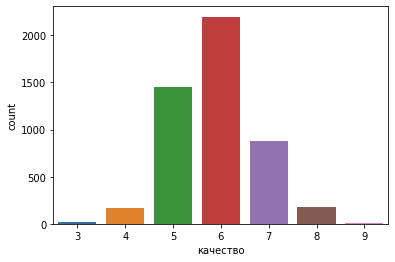

In [129]:
#Посмотрим на распределение значений качества
p = sns.countplot(data=df, x = 'качество')

Похоже, что оценки качества вина распределены нормально

In [130]:
df['качество'].describe()

count    4898.000000
mean        5.877909
std         0.885639
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: качество, dtype: float64

Оценка качества варьируется от 3 до 9, с преобладанием оценок "5" и "6"

Разделю вино на категории: плохое, среднее, хорошее:

In [150]:
conditions = [
    (df['качество'] > 6.5),
    (df['качество'] < 5)
]
rating = ['хорошее', 'плохое']
df['rating'] = np.select(conditions, rating, default='среднее')
df.rating.value_counts()

среднее    3655
хорошее    1060
плохое      183
Name: rating, dtype: int64

In [151]:
df.groupby('rating').mean()

,фикс. кислотность,летучая кислотность,лимонная кислота,остаточный сахар,хлориды,своб. диоксид серы,общ. диоксид серы,плотность,pH,сульфаты,спирт,качество
rating,,,,,,,,,,,,
плохое,7.180874,0.375984,0.307705,4.821038,0.050557,26.633880,130.232240,0.994343,3.183388,0.475956,10.173497,3.890710
среднее,6.876060,0.277086,0.337877,6.797729,0.047740,35.962107,142.571272,0.994480,3.180720,0.487557,10.269808,5.601368
хорошее,6.725142,0.265349,0.326057,5.261509,0.038160,34.550472,125.245283,0.992412,3.215132,0.500142,11.416022,7.174528


Исследую корреляцию между параметрами:

<AxesSubplot:>

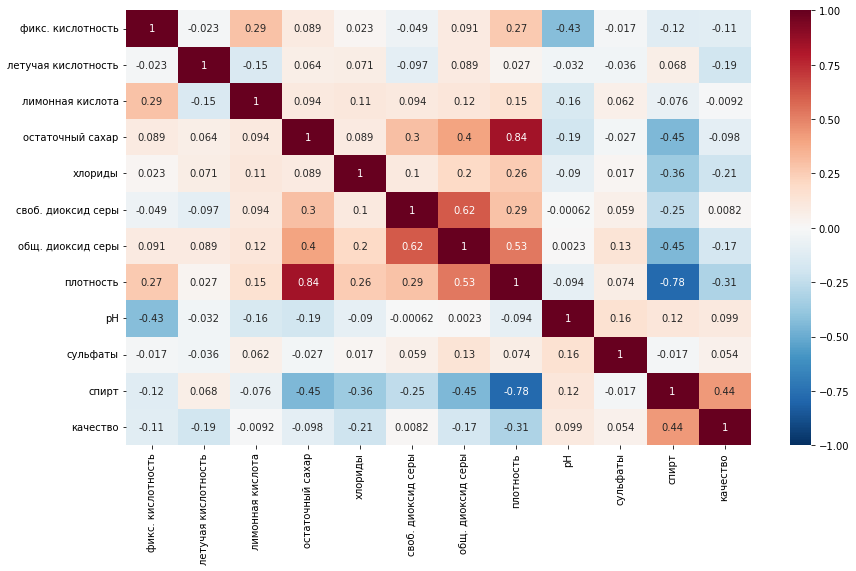

In [152]:
correlation = df.corr()
plt.figure(figsize=(14, 8))
sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

In [148]:
correlation['качество'].sort_values(ascending=False)

качество               1.000000
спирт                  0.435575
pH                     0.099427
сульфаты               0.053678
своб. диоксид серы     0.008158
лимонная кислота      -0.009209
остаточный сахар      -0.097577
фикс. кислотность     -0.113663
общ. диоксид серы     -0.174737
летучая кислотность   -0.194723
хлориды               -0.209934
плотность             -0.307123
Name: качество, dtype: float64

Как видно, наибольшая корреляция с качеством наблюдается у параметров спирт и pH, и обратная с плотностью и хлоридами,  
исследую их:

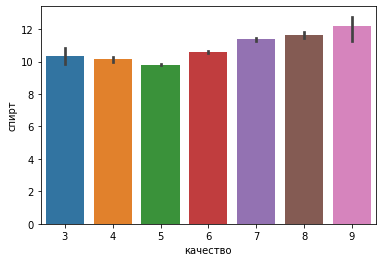

In [132]:
p = sns.barplot(data=df, x = 'качество',y='спирт')

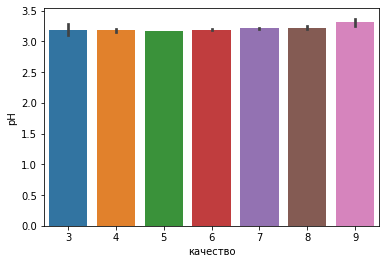

In [134]:
p = sns.barplot(data=df, x = 'качество',y='pH')

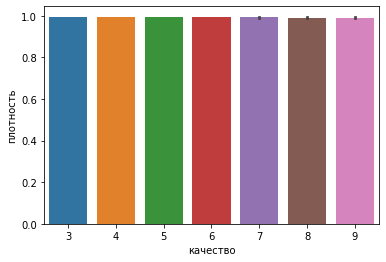

In [135]:
p = sns.barplot(data=df, x = 'качество',y='плотность')

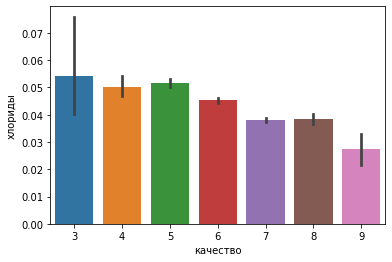

In [138]:
p = sns.barplot(data=df, x = 'качество',y='хлориды')

Из графиков выше не видно выраженной связи между качеством и плотностью, поэтому дальше буду исследовать без учета плотности. Так же наглядно видно, что 

Строю линейную регрессию с этими параметрами:

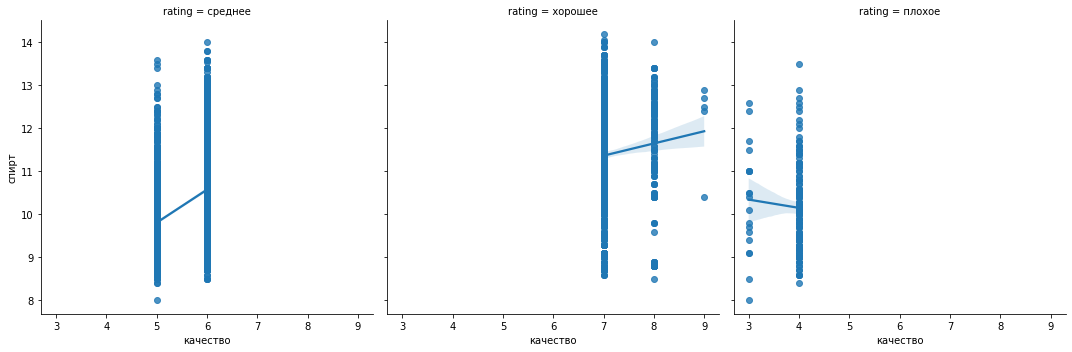

In [175]:
sns.lmplot(x = "качество", y = "спирт", col = "rating", data = df)

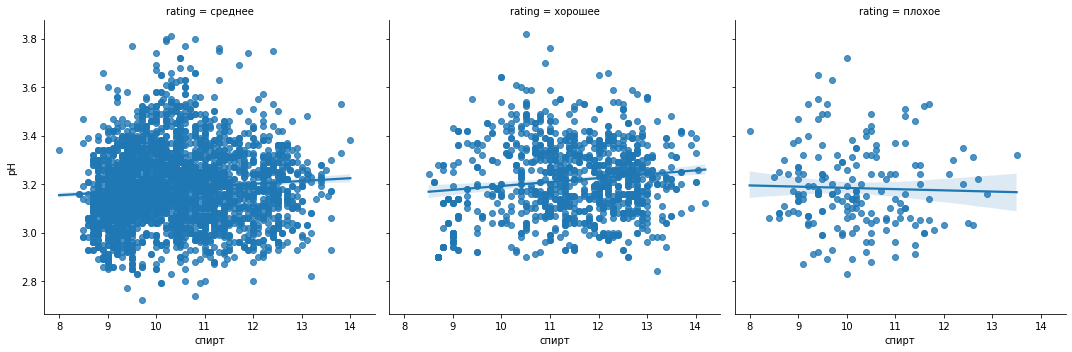

In [154]:
sns.lmplot(x = "спирт", y = "pH", col = "rating", data = df)

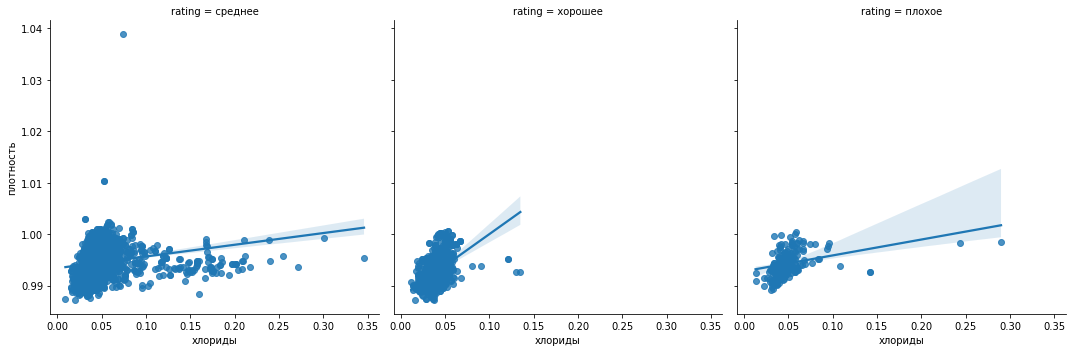

In [170]:
sns.lmplot(x = "хлориды", y = "плотность", col = "rating", data = df)

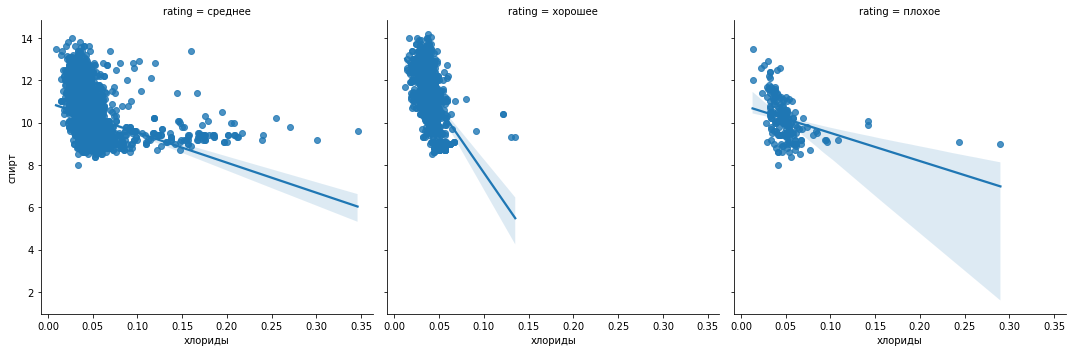

In [207]:
sns.lmplot(x = "хлориды", y = "спирт", col = "rating", data = df)

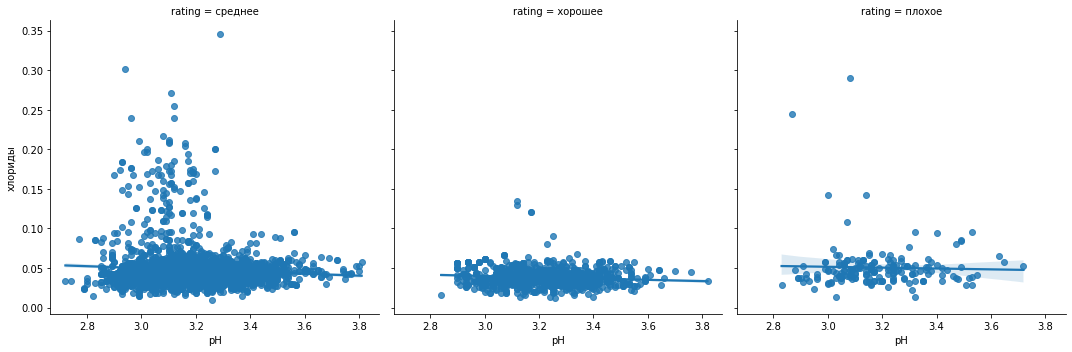

In [209]:
sns.lmplot(x = "pH", y = "хлориды", col = "rating", data = df)

Из графиков линейной регрессии похоже, что оценка качества вина растет с увеличением содержания алкоголя, причем начиная с ~11.5%, более низкое содержание скорее указывает на плохое качество напитка. Также незначительно на оценку качества влияют повышение показателя pH и понижение содержания хлоридов.

Применяю метод наименьших квадратов:

In [192]:
y,X = dmatrices('качество ~ спирт', data=df, return_type='dataframe')
print("X:", type(X))
print(X.columns)
model=sm.OLS(y, X)
result=model.fit()
result.summary()

X: <class 'pandas.core.frame.DataFrame'>
Index(['Intercept', 'спирт'], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               качество   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     1146.
Date:                Thu, 16 Dec 2021   Prob (F-statistic):          5.61e-226
Time:                        17:10:37   Log-Likelihood:                -5839.4
No. Observations:                4898   AIC:                         1.168e+04
Df Residuals:                    4896   BIC:                         1.170e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5820      0.098     26.345      0.000       2.390       2.774
спирт          0.3135      0.009     33.858      0.000       0.295       0.332
==============================================================================
Omnibus:                       88.780   Durbin-Watson:                   1.637
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.233
Skew:                           0.031   Prob(JB):                     7.29e-40
Kurtosis:                       3.938   Cond. No.                         91.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [194]:
model = sm.OLS.from_formula('качество ~ спирт', data = df)
results = model.fit()
print(results.params)

Intercept    2.582009
спирт        0.313469
dtype: float64


Получается, качество вина будет увеличиваться с каждым увеличением содержания спирта на 0.31 еденицу.

In [201]:
df['tier'] = (df['качество'] >= 6.5).astype(np.float32)

<AxesSubplot:ylabel='Density'>

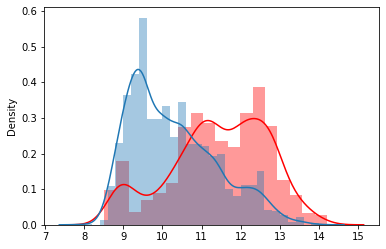

In [204]:
y, X = dmatrices('tier ~ спирт', data = df)
sns.distplot(X[y[:,0] > 0, 1], color="red")
sns.distplot(X[y[:,0] == 0, 1])

Отсюда видно, что вероятнее найти хорошее белое вино, когда содержание спирта в нем не меньше 11% и наоборот для плохого вина

In [220]:
model = sklearn.linear_model.LogisticRegression()
y,X = dmatrices('tier ~ спирт+ pH', data = df)
model.fit(X, y)
pred = model.predict(X)
print(sklearn.metrics.classification_report(y, pred))

              precision    recall  f1-score   support

         0.0       0.82      0.96      0.88      3838
         1.0       0.61      0.25      0.35      1060

    accuracy                           0.80      4898
   macro avg       0.71      0.60      0.62      4898
weighted avg       0.78      0.80      0.77      4898



In [223]:
model = sklearn.linear_model.LogisticRegression()
y,X = dmatrices('tier ~ спирт+ pH + хлориды', data = df)
model.fit(X, y)
pred = model.predict(X)
print(sklearn.metrics.classification_report(y, pred))

              precision    recall  f1-score   support

         0.0       0.82      0.96      0.88      3838
         1.0       0.61      0.25      0.35      1060

    accuracy                           0.80      4898
   macro avg       0.71      0.60      0.62      4898
weighted avg       0.77      0.80      0.77      4898



Таблица точности для логистической регрессии показывает точность предсказания качества хорошего вина 61% и 82% для плохого вина, ориентируясь только на кислотность и содержание спирта. Если добавлять параметры, точность предсказания падает, что вероятно означает вариативность вкусов дегустаторов, выставлявших оценки в данном датасете.

### Вывод:  
В результате этого исследования я обнаружил, что с неплохой вероятностью можно предсказывать качество напитка по содержанию в нем спирта и его кислотности. Второе я в магазине проверить не могу, но содержание спирта написано на бутылке, и это дает неплохие шансы получить хороший напиток. А точнее не получить плохой. С другой стороны, я еще не видел хорошего белого вина с содержанием спирта больше 12.5%, и обычно сторонюсь напитка с высоким содержанием спирта. Получается, это статистическое исследование идет в разрез с моим жизненным опытом и требует проверки опытным путем, чем я и собираюсь заняться.